# Importing necessary Modules and Packages

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
from collections import Counter
from sklearn.model_selection import train_test_split

# Importing attention modules

In [20]:
from attention_modules.BahdanauAttention import BahdanauAttention
from attention_modules.LuongDotAttention import LuongDotAttention
from attention_modules.LuongGeneralAttention import LuongGeneralAttention
from attention_modules.LuongConcatAttention import LuongConcatAttention

# Loading the dataset from Hugging Face

In [21]:
import pandas as pd

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])

In [22]:
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


# Preprocessing

### Preprocessing text:
* Converting all the letters into lowercase.
* Remove non alpha numeric characters.
* Splitting the sentences into tokens.
* Padding the sentences.


In [23]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', "", text)
    tokens = text.split()
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)

all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocal_counter = Counter(all_tokens)
vocab = ['<PAD>', '<UNK>'] + [word for word, freq in vocal_counter.items() if freq>=2]
word2idx = {word: idx for idx, word in enumerate(vocab)}

def encode_tokens(tokens, word2idx, max_len = 500):
    idxs = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    if len(idxs) < max_len :
        idxs += [word2idx['<PAD>']]*(max_len-len(idxs))
    else:
        idxs = idxs[:max_len]

    return idxs

df['input_ids'] = df['tokens'].apply(lambda tokens: encode_tokens(tokens, word2idx))

In [24]:
df.head()

,text,label,tokens,input_ids
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,"[i, rented, i, am, curiousyellow, from, my, vi...","[2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"[i, am, curious, yellow, is, a, risible, and, ...","[2, 4, 180, 181, 52, 40, 182, 89, 183, 184, 18..."
2,If only to avoid making this type of film in t...,0,"[if, only, to, avoid, making, this, type, of, ...","[31, 206, 34, 292, 73, 36, 293, 11, 155, 22, 1..."
3,This film was probably inspired by Godard's Ma...,0,"[this, film, was, probably, inspired, by, goda...","[36, 155, 19, 334, 335, 28, 336, 1, 1, 89, 2, ..."
4,"Oh, brother...after hearing about this ridicul...",0,"[oh, brotherafter, hearing, about, this, ridic...","[380, 1, 381, 67, 36, 382, 155, 48, 383, 112, ..."


### Splitting the data: 
* Splitting the dataset into $90-10$ ratio for train and validation purposes.
* Checking the size of each dataset.
* Checking the length of vocal obtained.

In [25]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])

def df_to_tensors(dataframe):
    X = torch.tensor(dataframe['input_ids'].tolist(), dtype=torch.long)
    y = torch.tensor(dataframe['label'].tolist(), dtype=torch.long)
    return X, y

X_train, y_train = df_to_tensors(train_df)
X_val, y_val = df_to_tensors(val_df)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print(f"Vocab size: {len(vocab)}")

Train shape: torch.Size([22500, 500]), Validation shape: torch.Size([2500, 500])
Vocab size: 57469


### Loading Embedding:
In this project I am using glove 100d embedding.

In [26]:
glove_path = 'glove.6B.100d.txt'
embedding_dim = 100

def load_glove_embeddings(glove_path):
    embedding_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
    return embedding_index

glove_embeddings = load_glove_embeddings(glove_path)

### Creating embedding matrix

In [27]:
#creating embedding matrix
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for i, word in enumerate(vocab):
    vector = glove_embeddings.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: torch.Size([57469, 100])


### Importing SentinmentRNN model and training BiLstm with Bahdanau Attention

In [ ]:
from model.SentimentRNN import SentimentRNN
hidden_size = 128
num_layers = 1
num_classes = 2

model_bilstm_attn = SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes)

model = model_bilstm_attn

c:\Users\RONIT\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [15]:
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

batch_size = 64
epochs = 5
lr = 1e-3

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Train Accuracy: {train_acc:.4f}", end='; ')

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc:.4f}")

# To train
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Epoch 1/5 - Train Loss: 0.5204 - Train Accuracy: 0.7207; Validation Accuracy: 0.8396
Epoch 2/5 - Train Loss: 0.3451 - Train Accuracy: 0.8532; Validation Accuracy: 0.8580
Epoch 3/5 - Train Loss: 0.3051 - Train Accuracy: 0.8727; Validation Accuracy: 0.8696
Epoch 4/5 - Train Loss: 0.2786 - Train Accuracy: 0.8832; Validation Accuracy: 0.8816
Epoch 5/5 - Train Loss: 0.2554 - Train Accuracy: 0.8939; Validation Accuracy: 0.8724


### Training few other models for analysis
* Each RNN, LSTM, BiRNN and BiLSTM without any attention.
* Each of them with Bahanau Attention.
* Plotting validation Accuracy of each of them to compare the result(which i have already discussed in the report).


Model: RNN


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.4920
Epoch 2/5 - Validation Accuracy: 0.5008
Epoch 3/5 - Validation Accuracy: 0.4996
Epoch 4/5 - Validation Accuracy: 0.5136
Epoch 5/5 - Validation Accuracy: 0.4888

Model: LSTM
Epoch 1/5 - Validation Accuracy: 0.5000
Epoch 2/5 - Validation Accuracy: 0.5172
Epoch 3/5 - Validation Accuracy: 0.5036
Epoch 4/5 - Validation Accuracy: 0.5156
Epoch 5/5 - Validation Accuracy: 0.5000

Model: BiRNN
Epoch 1/5 - Validation Accuracy: 0.5416
Epoch 2/5 - Validation Accuracy: 0.5016
Epoch 3/5 - Validation Accuracy: 0.6264
Epoch 4/5 - Validation Accuracy: 0.5960
Epoch 5/5 - Validation Accuracy: 0.5544

Model: BiLSTM
Epoch 1/5 - Validation Accuracy: 0.7164
Epoch 2/5 - Validation Accuracy: 0.7088
Epoch 3/5 - Validation Accuracy: 0.7432
Epoch 4/5 - Validation Accuracy: 0.8016
Epoch 5/5 - Validation Accuracy: 0.8244

Model: RNN+Attn
Epoch 1/5 - Validation Accuracy: 0.8400
Epoch 2/5 - Validation Accuracy: 0.8472
Epoch 3/5 - Validation Accuracy: 0.8468
Epoch 4/5 - Validatio

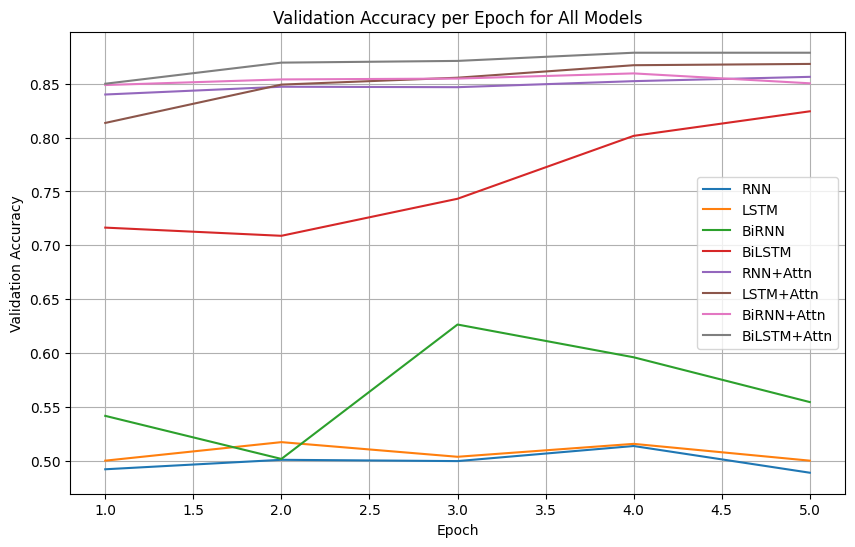

In [16]:
import matplotlib.pyplot as plt

model_variants = {
    "RNN": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=None, num_classes=num_classes),
    "LSTM": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=None, num_classes=num_classes),
    "BiRNN": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=None, num_classes=num_classes),
    "BiLSTM": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=None, num_classes=num_classes),
    "RNN+Attn": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=BahdanauAttention(hidden_size), num_classes=num_classes),
    "LSTM+Attn": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, attention=BahdanauAttention(hidden_size), num_classes=num_classes),
    "BiRNN+Attn": SentimentRNN(embedding_matrix, rnn_type='RNN', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes),
    "BiLSTM+Attn": SentimentRNN(embedding_matrix, rnn_type='LSTM', hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, attention=BahdanauAttention(hidden_size*2), num_classes=num_classes),
}

def train_model_return_val_acc(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    val_accs = []
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        val_acc = correct / total
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Validation Accuracy: {val_acc:.4f}")
    return val_accs

all_val_accs = {}
for name, model in model_variants.items():
    print(f"\nModel: {name}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_accs = train_model_return_val_acc(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)
    all_val_accs[name] = val_accs

plt.figure(figsize=(10,6))
for name, accs in all_val_accs.items():
    plt.plot(range(1, epochs+1), accs, label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch for All Models")
plt.legend()
plt.grid(True)
plt.show()

### Training few more models:
* Here I am training BiLSTM with each of the 4 types of attention to compare the results.
* I have plotted validation accuracy too.


Training BiLSTM + Bahdanau Attention
Epoch 1/5 - Validation Accuracy: 0.8424
Epoch 2/5 - Validation Accuracy: 0.8636
Epoch 3/5 - Validation Accuracy: 0.8608
Epoch 4/5 - Validation Accuracy: 0.8784
Epoch 5/5 - Validation Accuracy: 0.8760

Training BiLSTM + LuongDot Attention
Epoch 1/5 - Validation Accuracy: 0.8096
Epoch 2/5 - Validation Accuracy: 0.8416
Epoch 3/5 - Validation Accuracy: 0.8516
Epoch 4/5 - Validation Accuracy: 0.8648
Epoch 5/5 - Validation Accuracy: 0.8684

Training BiLSTM + LuongGeneral Attention
Epoch 1/5 - Validation Accuracy: 0.8236
Epoch 2/5 - Validation Accuracy: 0.8352
Epoch 3/5 - Validation Accuracy: 0.8688
Epoch 4/5 - Validation Accuracy: 0.8716
Epoch 5/5 - Validation Accuracy: 0.8648

Training BiLSTM + LuongConcat Attention
Epoch 1/5 - Validation Accuracy: 0.8436
Epoch 2/5 - Validation Accuracy: 0.8648
Epoch 3/5 - Validation Accuracy: 0.8712
Epoch 4/5 - Validation Accuracy: 0.8636
Epoch 5/5 - Validation Accuracy: 0.8752


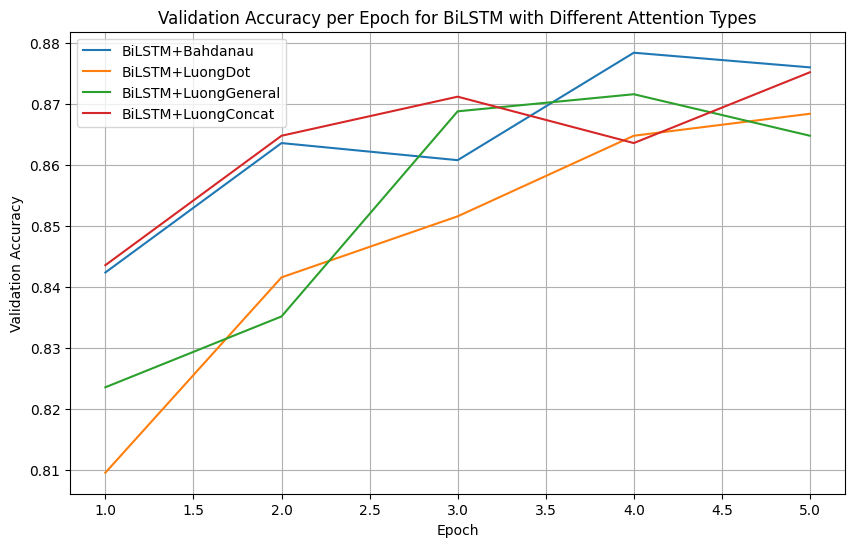

In [17]:
attention_types = {
    "Bahdanau": BahdanauAttention(hidden_size*2),
    "LuongDot": LuongDotAttention(),
    "LuongGeneral": LuongGeneralAttention(hidden_size*2),
    "LuongConcat": LuongConcatAttention(hidden_size*2),
}

bilstm_attn_val_accs = {}

for attn_name, attn_module in attention_types.items():
    print(f"\nTraining BiLSTM + {attn_name} Attention")
    model = SentimentRNN(
        embedding_matrix,
        rnn_type='LSTM',
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=True,
        attention=attn_module,
        num_classes=num_classes
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_accs = train_model_return_val_acc(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)
    bilstm_attn_val_accs[attn_name] = val_accs


# Plotting
plt.figure(figsize=(10,6))
for attn_name, accs in bilstm_attn_val_accs.items():
    plt.plot(range(1, epochs+1), accs, label=f"BiLSTM+{attn_name}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch for BiLSTM with Different Attention Types")
plt.legend()
plt.grid(True)
plt.show()

### Plotting Attention weights to visualize if attention weights makes sense or not.

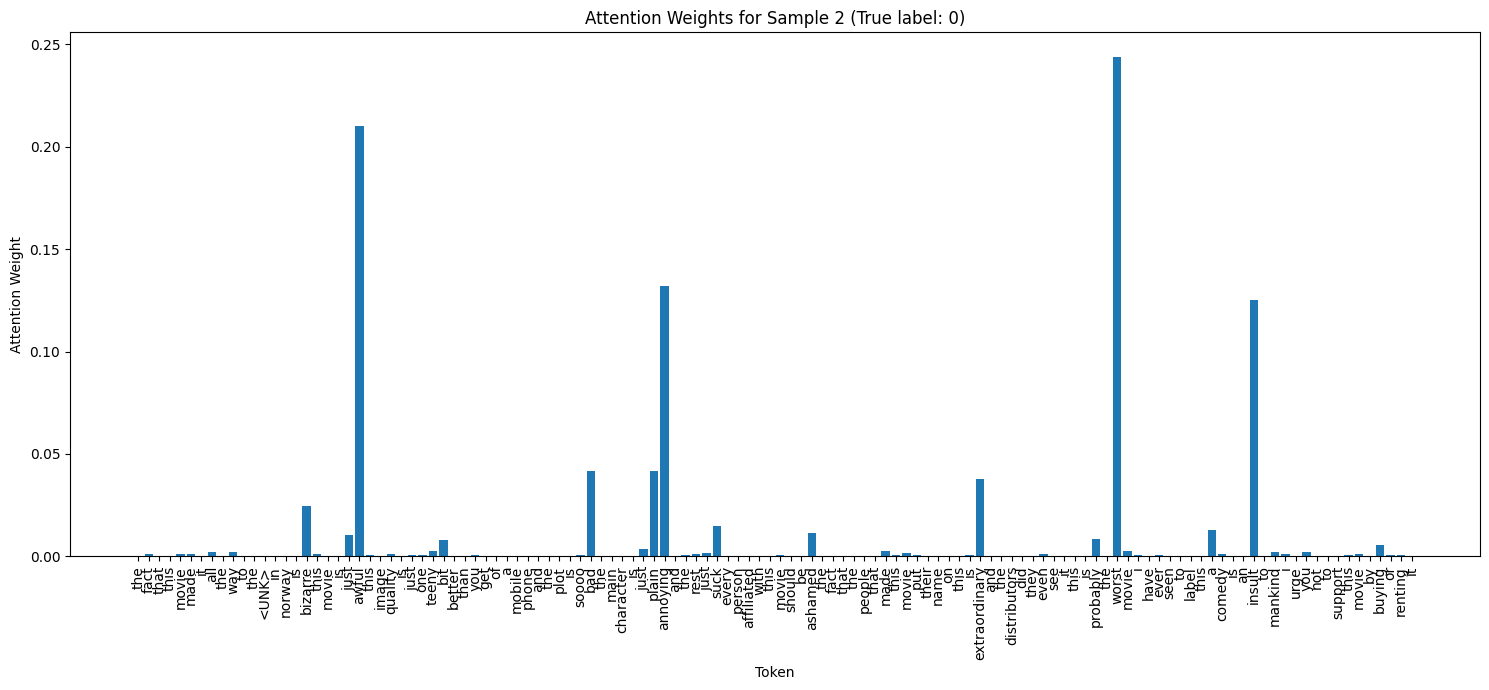

In [18]:
sample_idx = 2
sample_input = X_val[sample_idx].unsqueeze(0).to(device)
sample_label = y_val[sample_idx].item()
sample_tokens = [vocab[idx] for idx in X_val[sample_idx].cpu().numpy() if idx != word2idx['<PAD>']]

model.eval()
with torch.no_grad():
    output, attn_weights = model(sample_input)
    attn_weights = attn_weights.squeeze(0).cpu().numpy()

# Only plot non-padding tokens
attn_weights = attn_weights[:len(sample_tokens)]

plt.figure(figsize=(15, 7))
plt.bar(range(len(attn_weights)), attn_weights)
plt.xticks(range(len(sample_tokens)), sample_tokens, rotation=90)
plt.xlabel("Token")
plt.ylabel("Attention Weight")
plt.title(f"Attention Weights for Sample {sample_idx} (True label: {sample_label})")
plt.tight_layout()
plt.show()

### Classification Report and Confusion Matrix

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

model_bilstm_attn = model_bilstm_attn.to(device)
model_bilstm_attn.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs, _ = model_bilstm_attn(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("Classification Report (Validation Set):")
print(classification_report(all_labels, all_preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.8466    0.9096    0.8770      1250
           1     0.9023    0.8352    0.8675      1250

    accuracy                         0.8724      2500
   macro avg     0.8745    0.8724    0.8722      2500
weighted avg     0.8745    0.8724    0.8722      2500

Confusion Matrix:
[[1137  113]
 [ 206 1044]]
